# Load data and convert dtypes (duplicated from in eda notebook) 

In [36]:
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from numbers_parser import Document
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


In [7]:
# Read `.numbers` file using `numbers_parser` library
doc = Document("../data/Expanded_Football_Talent_Data.numbers")
sheets = doc.sheets
tables = sheets[0].tables
data = tables[0].rows(values_only=True)
# Convert to pandas for easier manipulation, as it's only 500 rows
df = pd.DataFrame(data[1:], columns=data[0])

# Define conversion schema e.g. 
# Convert `object` to `StringDtype` for strings
# Convert float64 to less memory extensive types e.g. float32
# Both can be skipped since we're dealing with a small dataset and memory isn't an issue
# Some columns e.g. score related columns were initially loaded as `object` rather a numerical type
schema = {
    "player_id": "Int32",
    "age": "float32",
    "gender": "string",
    "country": "string",
    "height_cm": "float32",
    "in_app_ranking": "float32",
    "coach_feedback_score": "float32",
    "video_performance_score": "float32",
    "behavior_score": "float32",
    "position": "string",
    "currently_in_club": "uint8",
    "club_interest": "uint8",
}
# Apply type conversion
for col, dtype in schema.items():
    if col in df.columns:
        df[col] = df[col].astype(dtype)

/Users/abrougui/.pyenv/versions/3.11.10/envs/ai_footbal_env/lib/python3.11/site-packages/numbers_parser/containers.py:50: RuntimeWarning: unsupported version '10.2.3'
  self._iwork.open(filepath)


# Basic pre-processsing, feature engineering and model training on data with highly imbalanced target

In [26]:
# Store a copy of the dataset and keep `df` intact
# No need to dropNa since the dataset does not have null values
df_w_basic_features = df.copy()
# Encode categorical variables
df_w_basic_features['gender'] = LabelEncoder().fit_transform(df_w_basic_features['gender'])
df_w_basic_features['country'] = LabelEncoder().fit_transform(df_w_basic_features['country'])
df_w_basic_features['favorite_position'] = LabelEncoder().fit_transform(df_w_basic_features['favorite_position'])

# Target and features
target = 'club_interest'
features = [
    'age', 'height_cm', 'video_performance_score', 'behavior_score', 
    'coach_feedback_score', 'gender', 'country', 'favorite_position', 
    'in_app_ranking',
]

X = df_w_basic_features[features]
y = df_w_basic_features[target]

# Normalize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)


In [32]:
# Assign weights to objective function due to imbalanced target
lr_model = LogisticRegression(class_weight='balanced')
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

print("Logistic Regression Report:\n", classification_report(y_test, y_pred_lr))

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.72      0.60      0.65        92
           1       0.24      0.36      0.29        33

    accuracy                           0.54       125
   macro avg       0.48      0.48      0.47       125
weighted avg       0.60      0.54      0.56       125


In [33]:
# Similarly as with LR use weighted loss 
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Report:\n", classification_report(y_test, y_pred_xgb))

XGBoost Report:
               precision    recall  f1-score   support

           0       0.74      0.77      0.76        92
           1       0.28      0.24      0.26        33

    accuracy                           0.63       125
   macro avg       0.51      0.51      0.51       125
weighted avg       0.62      0.63      0.62       125


/Users/abrougui/.pyenv/versions/3.11.10/envs/ai_footbal_env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:17:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


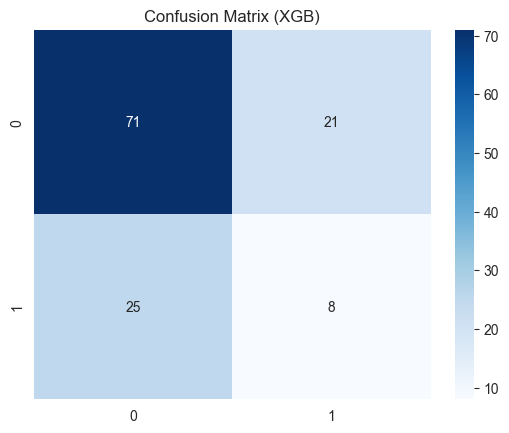

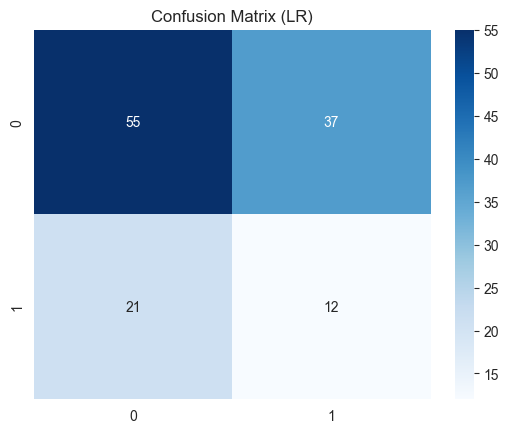

In [34]:
# Confusion matrix (xgb)
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (XGB)")
plt.show()
# Confusion matrix (LR)
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (LR)")
plt.show()

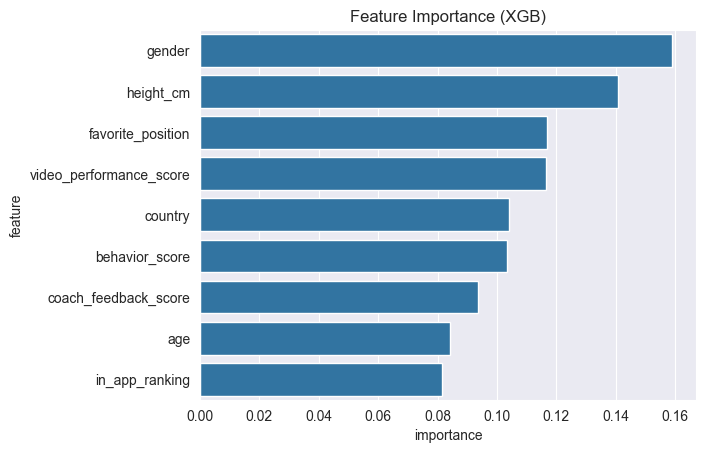

In [35]:
# Feature importance, just for xgb
feature_importances = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame(
    {'feature': features, 'importance': feature_importances}
).sort_values(by='importance', ascending=False)
# Plot
sns.barplot(data=feature_importance_df, x='importance', y='feature')
plt.title("Feature Importance (XGB)")
plt.show()

# Custom pre-processing, feature engineering and model training

In [80]:
# Basic encoding
df_w_custom_features = df.dropna().copy()
df_w_custom_features['gender'] = LabelEncoder().fit_transform(df_w_custom_features['gender'])
df_w_custom_features['country'] = LabelEncoder().fit_transform(df_w_custom_features['country'])
df_w_custom_features['favorite_position'] = LabelEncoder().fit_transform(df_w_custom_features['favorite_position'])

# Feature Engineering
# Create an average score feature to smooth noise since individual scores 
# were not indicative much and had poor correlation with `club_interest`
df_w_custom_features['avg_score'] = df_w_custom_features[
    ['video_performance_score', 'behavior_score', 'coach_feedback_score']
].mean(axis=1)
# Captures inconsistency in player scores in case of imbalanced behavior
df_w_custom_features['score_range'] = (
        df_w_custom_features[[
            'video_performance_score', 
            'behavior_score', 
            'coach_feedback_score',
        ]].max(axis=1) - 
        df_w_custom_features[[
            'video_performance_score', 
            'behavior_score', 
            'coach_feedback_score',
        ]].min(axis=1)
)
# Models the peak of club interest at age 18
df_w_custom_features['is_adult'] = (df_w_custom_features['age'] >= 18).astype(int)


# Select features
features = [
    'age', 'height_cm', 'gender', 'country', 'favorite_position', 'in_app_ranking',
    'video_performance_score', 'behavior_score', 'coach_feedback_score',
    'avg_score', 'score_range', 'is_adult'
]
target = 'club_interest'

X = df_w_custom_features[features]
y = df_w_custom_features[target]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_scaled, y)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)


In [81]:
# Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression:\n", classification_report(y_test, y_pred_lr))

# XGBoost

xgb_model = XGBClassifier(use_label_encoder=False)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost:\n", classification_report(y_test, y_pred_xgb))


Logistic Regression:
               precision    recall  f1-score   support

           0       0.53      0.51      0.52        74
           1       0.52      0.53      0.53        73

    accuracy                           0.52       147
   macro avg       0.52      0.52      0.52       147
weighted avg       0.52      0.52      0.52       147

XGBoost:
               precision    recall  f1-score   support

           0       0.86      0.81      0.83        74
           1       0.82      0.86      0.84        73

    accuracy                           0.84       147
   macro avg       0.84      0.84      0.84       147
weighted avg       0.84      0.84      0.84       147


/Users/abrougui/.pyenv/versions/3.11.10/envs/ai_footbal_env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:48:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


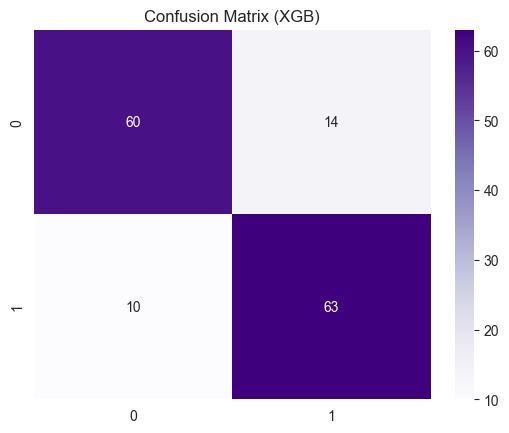

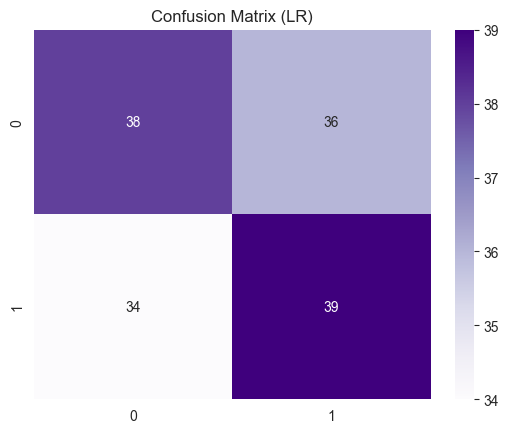

In [82]:
# Confusion matrix (xgb)
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix (XGB)")
plt.show()
# Confusion matrix (LR)
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix (LR)")
plt.show()